
## 텐서플로2를 통한 분류 모델로 음주여부 예측하기

* 건강검진 센터에서 음주여부에 응답을 하지 않는 사람이 있다고 가정합니다.
* 검진 데이터를 바탕으로 음주여부를 예측한다면 건강한 생활습관을 가이드하는데 도움이 될 것 입니다.
* 분류기 모델을 사용해서 건강검진 데이터를 바탕으로 음주여부를 예측해 봅니다.


### 01. 라이브러리 로드
----

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 한글깨짐 설정
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic') 

In [2]:
df = pd.read_csv("health.csv")
df.shape

(10000, 34)

### 02. 탐색적 데이터 분석
---

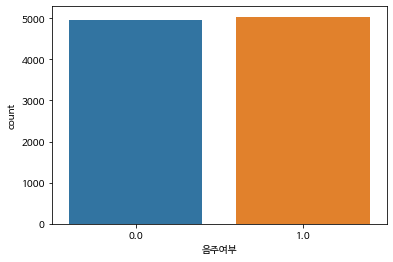

In [3]:
sns.countplot(data=df, x="음주여부")
plt.show()

음주 여부는 거의 비슷한 비율로 존재합니다.

In [4]:
df.isnull().sum()

기준년도                0
가입자일련번호             0
성별코드                0
연령대코드(5세단위)         0
시도코드                0
신장(5Cm단위)           1
체중(5Kg 단위)          1
허리둘레                0
시력(좌)               3
시력(우)               3
청력(좌)               1
청력(우)               1
수축기혈압               0
이완기혈압               0
식전혈당(공복혈당)          0
총콜레스테롤              0
트리글리세라이드            0
HDL콜레스테롤            0
LDL콜레스테롤           27
혈색소                 0
요단백                38
혈청크레아티닌             0
(혈청지오티)AST          0
(혈청지오티)ALT          0
감마지티피               0
흡연상태                1
음주여부                0
구강검진 수검여부           0
치아우식증유무         10000
결손치유무           10000
치아마모증유무         10000
제3대구치(사랑니)이상    10000
치석               6059
데이터공개일자             0
dtype: int64

결측치가 5000개 이상인 '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석' 컬럼은 제거합니다.

In [5]:
df = df.drop([ '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석'], axis=1)
df.columns

Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)',
       '체중(5Kg 단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진 수검여부', '데이터공개일자'],
      dtype='object')

In [6]:
# 요단백 컬럼의 결측치를 최빈값으로 대체
mode = df["요단백"].mode()[0]
df["요단백"] = df['요단백'].fillna(mode)

# LDL 콜레스테롤은 중앙값으로 대체
ldl_median = df.loc[(df["LDL콜레스테롤"].notnull()), "LDL콜레스테롤"].median()
df["LDL콜레스테롤"] = df['LDL콜레스테롤'].fillna(ldl_median)

In [7]:
df_null = df.isnull().sum()
df_null[df_null != 0]

신장(5Cm단위)     1
체중(5Kg 단위)    1
시력(좌)         3
시력(우)         3
청력(좌)         1
청력(우)         1
흡연상태          1
dtype: int64

나머지 결측치가 있는 행은 많지 않으니 drop 합니다.

In [8]:
df = df.dropna()
df.isnull().sum()

기준년도           0
가입자일련번호        0
성별코드           0
연령대코드(5세단위)    0
시도코드           0
신장(5Cm단위)      0
체중(5Kg 단위)     0
허리둘레           0
시력(좌)          0
시력(우)          0
청력(좌)          0
청력(우)          0
수축기혈압          0
이완기혈압          0
식전혈당(공복혈당)     0
총콜레스테롤         0
트리글리세라이드       0
HDL콜레스테롤       0
LDL콜레스테롤       0
혈색소            0
요단백            0
혈청크레아티닌        0
(혈청지오티)AST     0
(혈청지오티)ALT     0
감마지티피          0
흡연상태           0
음주여부           0
구강검진 수검여부      0
데이터공개일자        0
dtype: int64

In [123]:
df.describe()

,기준년도,가입자일련번호,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,이완기혈압,식전혈당(공복혈당),총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,구강검진 수검여부,데이터공개일자
count,9996.0,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.0
mean,2017.0,501659.454482,1.465086,10.577131,33.625050,162.264406,63.493898,81.350950,0.978631,0.971679,1.031212,1.030312,122.628451,76.170668,100.455782,196.230792,132.501701,56.871449,113.714486,14.248119,1.096939,0.863946,26.216887,25.742497,37.613345,1.614346,0.503902,0.393958,20181126.0
std,0.0,288887.534006,0.498804,2.835132,12.782823,9.466616,12.958743,9.720863,0.618407,0.583952,0.173900,0.171453,14.367046,9.786019,23.982016,38.267078,104.535802,14.906102,34.780206,1.585464,0.449898,0.368959,20.679971,21.421647,50.563295,0.818636,0.500010,0.488650,0.0
min,2017.0,79.000000,1.000000,5.000000,11.000000,125.000000,30.000000,52.000000,0.100000,0.100000,1.000000,1.000000,72.000000,46.000000,38.000000,79.000000,18.000000,10.000000,1.000000,6.300000,1.000000,0.100000,2.000000,3.000000,3.000000,1.000000,0.000000,0.000000,20181126.0
25%,2017.0,250564.500000,1.000000,9.000000,26.000000,155.000000,55.000000,75.000000,0.700000,0.700000,1.000000,1.000000,112.000000,70.000000,89.000000,170.000000,74.000000,46.000000,90.000000,13.200000,1.000000,0.700000,19.000000,15.000000,16.000000,1.000000,0.000000,0.000000,20181126.0
50%,2017.0,504182.000000,1.000000,11.000000,41.000000,160.000000,60.000000,81.000000,1.000000,1.000000,1.000000,1.000000,121.000000,76.000000,96.000000,194.000000,107.000000,55.000000,111.000000,14.300000,1.000000,0.800000,23.000000,20.000000,23.500000,1.000000,1.000000,0.000000,20181126.0
75%,2017.0,751431.750000,2.000000,13.000000,44.000000,170.000000,70.000000,88.000000,1.200000,1.200000,1.000000,1.000000,131.000000,82.000000,105.000000,220.000000,160.000000,66.000000,135.000000,15.400000,1.000000,1.000000,28.000000,30.000000,40.000000,2.000000,1.000000,1.000000,20181126.0
max,2017.0,999889.000000,2.000000,18.000000,50.000000,195.000000,150.000000,145.000000,9.900000,9.900000,2.000000,2.000000,207.000000,141.000000,429.000000,725.000000,3165.000000,144.000000,363.000000,19.900000,6.000000,16.300000,1282.000000,533.000000,999.000000,3.000000,1.000000,1.000000,20181126.0


LDL의 최댓값이 363, 최소가 1, TG 최대가 3165, 감마지티피가 999인 것은 이상치로 보입니다. 이상치는 제거하겠습니다.

---



In [149]:
# 이상치 제거
drop_index = df[(df['LDL콜레스테롤'] < 10) | (df['LDL콜레스테롤'] > 300) | (df['트리글리세라이드'] > 500) | (df['감마지티피'] > 300)].index
df = df.drop(drop_index)

### 03. 모델링
----


In [150]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

X = df.drop('음주여부', axis=1)
y = df['음주여부']

X['성별코드'] = X['성별코드'].astype('str')
X['흡연상태'] = X['흡연상태'].astype('str')

X = pd.get_dummies(X)

# train, test set 생성
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# feature importance를 확인하기 위한 model 생성
# rf_clf = RandomForestClassifier(n_estimators=1000)
rf_clf = XGBClassifier()
rf_clf.fit(X_train, y_train)

(7882, 31) (1971, 31) (7882,) (1971,)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

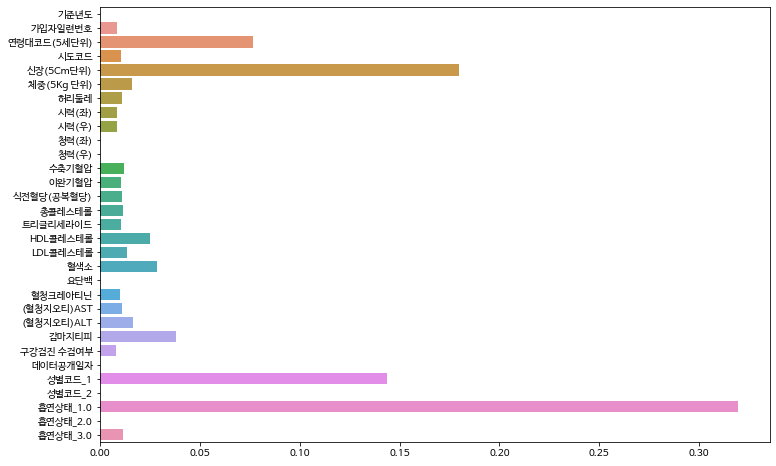

In [151]:
# RandomForest Classifier의 feature importance 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=rf_clf.feature_importances_, y=X_train.columns)
plt.show()

Randomforest classifier 결과에서 feature importance가 작은 '기준년도', '시도코드', '가입자일련번호', '청력(좌)', '청력(우)', '데이터공개일자' 컬럼은 drop하겠습니다.

In [152]:
X_train = X_train.drop(['기준년도', '시도코드', '가입자일련번호', '청력(좌)', '청력(우)', '데이터공개일자'], axis=1)
X_test = X_test.drop(['기준년도', '시도코드', '가입자일련번호', '청력(좌)', '청력(우)', '데이터공개일자'], axis=1)

print(X_train.columns)

Index(['연령대코드(5세단위)', '신장(5Cm단위)', '체중(5Kg 단위)', '허리둘레', '시력(좌)', '시력(우)',
       '수축기혈압', '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤',
       'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT',
       '감마지티피', '구강검진 수검여부', '성별코드_1', '성별코드_2', '흡연상태_1.0', '흡연상태_2.0',
       '흡연상태_3.0'],
      dtype='object')


In [153]:
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(42)
input_shape = X_train.shape[1]

model = keras.Sequential([
  keras.layers.Dense(32, activation='swish', input_shape=[input_shape]),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(1, activation='sigmoid')
])

In [154]:
# 모델 컴파일
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [155]:
# 모델 요약
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 32)                832       
_________________________________________________________________
dropout_35 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_36 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 16)              

In [156]:
# train

history = model.fit(X_train, y_train, epochs=300, verbose=0, validation_split=0.2)

In [157]:
# 학습결과의 history 값을 가져와서 비교하기 위해 데이터프레임으로 변환
df_hist = pd.DataFrame(history.history)

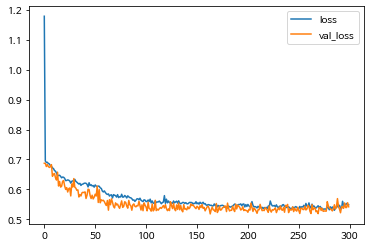

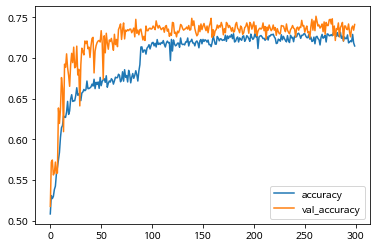

In [158]:
# loss, accuracy 값 시각화 
df_hist[['loss', 'val_loss']].plot()
df_hist[['accuracy', 'val_accuracy']].plot()

### 04. 평가
----

In [159]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\n테스트 정확도:', test_acc)

62/62 - 0s - loss: 0.5396 - accuracy: 0.7291

테스트 정확도: 0.7290715575218201
